# 0 Required imports, hyperparameters and general functions

## 0.1 Required imports

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage.feature import hog
import glob
import time
import pickle

## 0.2 Hyperparameters

In [2]:
# HYPERPARAMETERS

# Hog features
color_space = "YCrCb"
orient=9
pix_per_cell=8
cell_per_block=2
hog_channel = "2"
classifier_shape = (64,64) # Defines the image shape required for the classifier

test_size=0.2




y_start = 400
y_stop = 620
input_image_shape_x = 1280
input_image_shape_y = 720
y_window_gap = 20 # Pixel gap between windows in y direction
x_num_windows = 20 # Number of frames which will be distributed along the x-axis on one y level

y_window_h_min = 30 # Number of pixels for the minimum window hight of the top frame (must not be larger than 2* 
                    # y_window_gap)

window_ratio = 1.5 # window ratio * window hight = window width



## 0.3 Plotting functions

In [3]:
def plot_and_save_n_images(imgs, cmaps, headings, save = False, save_path = None,
                          images_per_column = 1, images_per_line = 2, figw = 8, figh = 4):
    """
    Plots n images in this notebook and optionally saves the figure in one file
    Input:
    imgs (np.array): Image to be plotted
    cmap (str): Cmap for plotting if required
    heading (str): Heading to be displayed above image
    save (bool): Indicates whether image should be saved or not
    save_path (str): Path to where the image should be saved
    """
    
    fig, axes = plt.subplots(images_per_column,images_per_line,figsize = (figw,figh))
    for i, ax in enumerate(axes.flat):
        if i in range(len(imgs)):
            ax.imshow(imgs[i],cmap = cmaps[i])
            ax.axis("off")
            if headings[i]:
                ax.set_title("{}".format(headings[i]),fontsize = 15, fontweight='bold')
        else:
            ax.axis("off")
    plt.tight_layout()
    plt.axis("off")
    if save:
        fig.savefig(save_path)
    plt.show()

# 1 Create detection classifier (Histogram of Oriented Gradients (HOG))

## 1.1 Initialize images and labels

In [4]:
def extract_train_test_from_folder(folder_path,test_size):
    img_names = sorted(glob.glob("{}/*".format(folder_path)))
    imgs = np.array([mpimg.imread(image_path) for image_path in img_names])
    
    split_value = int((1-test_size)*len(img_names))
    imgs_train = np.array(imgs[:split_value])
    imgs_test = np.array(imgs[split_value:])
    return imgs_train, imgs_test

In [5]:
def generate_train_test(folders,vehicle):
    X_train = []
    X_test = []

    for folder in folders:
        tmp_X_train, tmp_X_test = extract_train_test_from_folder(folder,test_size)
        X_train.append(tmp_X_train)
        X_test.append(tmp_X_test)

    X_train = np.concatenate(X_train)
    X_test = np.concatenate(X_test)
    if vehicle:
        y_train = np.ones(len(X_train))
        y_test = np.ones(len(X_test))
    else:
        y_train = np.zeros(len(X_train))
        y_test = np.zeros(len(X_test))
    
    return X_train, X_test, y_train, y_test

In [6]:
# Get image names
vehicles_folders = glob.glob('labeled_data/vehicles/*')
non_vehicles_folders = glob.glob('labeled_data/non-vehicles/*')

# Generate training and test data for vehicle objects
X_train_veh, X_test_veh, y_train_veh, y_test_veh = generate_train_test(vehicles_folders,1)

# Generate training and test data for non-vehicle objects
X_train_non_veh, X_test_non_veh, y_train_non_veh, y_test_non_veh = generate_train_test(non_vehicles_folders,0)

# Concatenate data for vehicle and non-vehicle objects to create training and testing data
X_train = np.concatenate((X_train_veh,X_train_non_veh))
X_test = np.concatenate((X_test_veh,X_test_non_veh))
y_train = np.concatenate((y_train_veh, y_train_non_veh))
y_test = np.concatenate((y_test_veh, y_test_non_veh))

# Shuffle training and testing data
X_train,y_train = shuffle(X_train,y_train)
X_test,y_test = shuffle(X_test,y_test)

In [7]:
"""non_vehicles_names = glob.glob('labeled_data/non-vehicles/*/*.png')
non_vehicle_X = np.array([mpimg.imread(image_path) for image_path in non_vehicles_names])
non_vehicle_y = np.zeros(non_vehicle_X.shape[0])
X_train_non_veh, X_test_non_veh, y_train_non_veh, y_test_non_veh = train_test_split(non_vehicle_X, 
                                                                                    non_vehicle_y, 
                                                                                    test_size = test_size)"""

"non_vehicles_names = glob.glob('labeled_data/non-vehicles/*/*.png')\nnon_vehicle_X = np.array([mpimg.imread(image_path) for image_path in non_vehicles_names])\nnon_vehicle_y = np.zeros(non_vehicle_X.shape[0])\nX_train_non_veh, X_test_non_veh, y_train_non_veh, y_test_non_veh = train_test_split(non_vehicle_X, \n                                                                                    non_vehicle_y, \n                                                                                    test_size = test_size)"

In [8]:
"""# Load images
try:
    with open("X_images.p","wb") as X_images:
        X = pickle.load(X_images)
    with open("y_labels.p","wb") as y_labels:
        y = pickle.load(y_labels)
    print("Images were loaded from pickle file")

except:
    imgs_vehicle = glob.glob('labeled_data/vehicles/*/*.png')
    imgs_non_vehicle = glob.glob('labeled_data/non-vehicles/*/*.png')

    # Define y values
    y = np.concatenate((np.ones(len(imgs_vehicle)),np.zeros(len(imgs_non_vehicle))))

    X_veh = [mpimg.imread(image_path) for image_path in imgs_vehicle]
    X_n_veh = [mpimg.imread(image_path) for image_path in imgs_non_vehicle]

    X = np.concatenate((X_veh,X_n_veh))
    
    with open("X_images.p","wb") as X_images:
        pickle.dump(X, X_images)
    with open("y_labels.p","wb") as y_labels:
        pickle.dump(y,y_labels)
        
        
print("Shape of feature array:\t{}\nShape of label array:\t{}".format(X.shape,y.shape))"""

'# Load images\ntry:\n    with open("X_images.p","wb") as X_images:\n        X = pickle.load(X_images)\n    with open("y_labels.p","wb") as y_labels:\n        y = pickle.load(y_labels)\n    print("Images were loaded from pickle file")\n\nexcept:\n    imgs_vehicle = glob.glob(\'labeled_data/vehicles/*/*.png\')\n    imgs_non_vehicle = glob.glob(\'labeled_data/non-vehicles/*/*.png\')\n\n    # Define y values\n    y = np.concatenate((np.ones(len(imgs_vehicle)),np.zeros(len(imgs_non_vehicle))))\n\n    X_veh = [mpimg.imread(image_path) for image_path in imgs_vehicle]\n    X_n_veh = [mpimg.imread(image_path) for image_path in imgs_non_vehicle]\n\n    X = np.concatenate((X_veh,X_n_veh))\n    \n    with open("X_images.p","wb") as X_images:\n        pickle.dump(X, X_images)\n    with open("y_labels.p","wb") as y_labels:\n        pickle.dump(y,y_labels)\n        \n        \nprint("Shape of feature array:\t{}\nShape of label array:\t{}".format(X.shape,y.shape))'

## 1.2 Extract image features

In [9]:
# Define a function to extract hog-features from a list of images
def extract_features(imgs, color_space, orient, pix_per_cell, cell_per_block, hog_channel, classifier_shape):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in imgs:
        
        # Resize image
        img = (cv2.resize(img,dsize=classifier_shape)/255).astype(np.float32)
        
        # apply color conversion if other than 'RGB'
        if color_space == 'HSV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)/255
        elif color_space == 'LUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)/255
            
        # Create color features based on RGB input image
        col_features =  (cv2.resize(np.copy(img),(24,24))/255).ravel()       
        
        # Get hog features
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(img.shape[2]):
                hog_features.append(hog(img[:,:,channel],orientations=orient,
                                            pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                            cells_per_block=(cell_per_block, cell_per_block), 
                                            transform_sqrt=True, visualise=False, feature_vector=True))
            hog_features = np.ravel(hog_features)

        
        else:
            hog_features = hog(img[:,:,hog_channel], orientations=orient,
                                            pixels_per_cell=(pix_per_cell, pix_per_cell), 
                                            cells_per_block=(cell_per_block, cell_per_block), 
                                            transform_sqrt=True, visualise=False, feature_vector=True)
            
        features.append(np.concatenate((hog_features,col_features)))
        
   
    
    # Return list of feature vectors
    return features

In [10]:
X_train_feat = extract_features(X_train, color_space, orient, pix_per_cell, cell_per_block, hog_channel,
                                classifier_shape)

X_test_feat = extract_features(X_test, color_space, orient, pix_per_cell, cell_per_block, hog_channel,
                               classifier_shape)

# Fit a per-column scaler
features_scaler = StandardScaler().fit(np.concatenate((X_train_feat,X_test_feat)))
                                       
# Apply the scaler to features
X_train_feat = features_scaler.transform(X_train_feat)
X_test_feat = features_scaler.transform(X_test_feat)                                       

/home/wolfgang/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [11]:
"""# Extract features
try:
    with open("X_features.p","rb") as X_feat:
        X_features = pickle.load(X_feat)
    print("Features were loaded from pickle file")
except:
    features = extract_features(X, color_space, orient, pix_per_cell, cell_per_block, hog_channel,
                                classifier_shape)
    
    # Fit a per-column scaler
    features_scaler = StandardScaler().fit(features)

    # Apply the scaler to features
    X_features = features_scaler.transform(features)
    
    
    with open("X_features.p","wb") as X_feat:
        pickle.dump(X, X_feat)"""

'# Extract features\ntry:\n    with open("X_features.p","rb") as X_feat:\n        X_features = pickle.load(X_feat)\n    print("Features were loaded from pickle file")\nexcept:\n    features = extract_features(X, color_space, orient, pix_per_cell, cell_per_block, hog_channel,\n                                classifier_shape)\n    \n    # Fit a per-column scaler\n    features_scaler = StandardScaler().fit(features)\n\n    # Apply the scaler to features\n    X_features = features_scaler.transform(features)\n    \n    \n    with open("X_features.p","wb") as X_feat:\n        pickle.dump(X, X_feat)'

## 1.3 Initialize training and testing data

In [12]:
"""# Perform split in train and test data
X_train, X_test, y_train, y_test = train_test_split (X_features,y,test_size = 0.2)"""

'# Perform split in train and test data\nX_train, X_test, y_train, y_test = train_test_split (X_features,y,test_size = 0.2)'

## 1.4 Fit and test classifier (SVM)

In [13]:
# Create classifier

"""try:
    # Try to load classifier from pickle (if fitted earlier)
    with open("classifier.p","rb") as cls:
        svc = pickle.load(cls)
    print("Classifier were loaded from pickel file.")"""
    
#except:

# Define SVM classifier
svc = LinearSVC()

# Fit classifier
t1 = time.time()
svc.fit(X_train_feat, y_train)
t2 = time.time()
print("Seconds to train classifier:\t{:.2f}".format(t2-t1))

# Dump classifier in pickle file
#with open("classifier.p","wb") as cls:
    #pickle.dump(svc,cls)

Seconds to train classifier:	12.66


In [14]:
# Evaluate classifier
accuracy = svc.score(X_test_feat, y_test)
print("Accuracy of current classifier:\t{:.4f}".format(accuracy))

Accuracy of current classifier:	0.9398


In [15]:
"""imgs_test_case = glob.glob('labeled_data/non-vehicles/Extras/*.png')
X_test_case = [mpimg.imread(image_path) for image_path in imgs_test_case]
X_test_features = extract_features(X_test_case, color_space, orient, pix_per_cell, cell_per_block, 
                                   hog_channel,classifier_shape)"""

"imgs_test_case = glob.glob('labeled_data/non-vehicles/Extras/*.png')\nX_test_case = [mpimg.imread(image_path) for image_path in imgs_test_case]\nX_test_features = extract_features(X_test_case, color_space, orient, pix_per_cell, cell_per_block, \n                                   hog_channel,classifier_shape)"

In [16]:
"""X_test_features_scaled = features_scaler.transform(X_test_features)
test_predict = svc.predict(X_test_features_scaled)

print(test_predict[:100])"""

'X_test_features_scaled = features_scaler.transform(X_test_features)\ntest_predict = svc.predict(X_test_features_scaled)\n\nprint(test_predict[:100])'

# 2 Sliding Window Search

## 2.1 Define windows

In [17]:
# Read in test images

# Get all test image names
test_img_names = sorted(glob.glob('test_images/*.jpg'))

# Load test images into np.array
test_imgs = np.array([mpimg.imread(name) for name in test_img_names])
    
print("Shape of test image array:\n{}".format(test_imgs.shape))

Shape of test image array:
(6, 720, 1280, 3)


In [18]:
def plot_and_save_test_imgs(img, y_start,y_stop, rectangle = False, point_1 = None, point_2 = None, 
                            img_save = False, save_path = None):
    """
    Enables display, adding of rectangled windows and saving of test images
    
    Input:
    img (np.array): Test image to be plotted, (rectangled and saved). E.g. 'test_imgs[0]'
    y_start (int): Starting pixel value of the new image in input image terms
    y_stop (int): Ending pixel value of the new image in input image terms
    rectangle (bool): Indicates, whether rectangle should be displayed on image
    point_1 (tuple): First corner point for the rectangle
    point_2 (tuple): Second corner point for the rectangle
    img_save (bool): Indicates, whether image should be saved
    save_path (str): Path for saving
    """
    img_plt = np.copy(img)
    if rectangle:
        cv2.rectangle(img_plt, point_1, point_2,(0,0,255),6)
    plt.imshow(img_plt)
    plt.axis("off")
    if img_save:
        plt.imsave(save_path,img_plt)

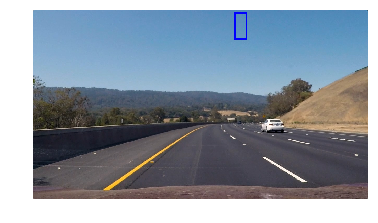

In [19]:
# Test plot_and_save_test_imgs() function and print outputs
plot_and_save_test_imgs(test_imgs[2], y_start,y_stop, rectangle = True, 
                        point_1 = (770, 10), point_2 = (815,110),img_save = True, save_path = "test.png")

In [20]:
def generate_windows(y_start, y_stop, x_start, x_stop, win_per_row, win_per_col, window_size):
    y_size = y_stop-y_start
    x_size = x_stop-x_start
    window_stride_y = (y_size - window_size[1]) // (win_per_col-1)
    window_stride_x = (x_size - window_size[0]) // (win_per_row-1)
    
    window_positions = []
    
    for row in range(win_per_col):
        y_low = y_start + row * window_stride_y
        y_high = y_low + window_size[1]
        for col in range(win_per_row):
            x_low = x_start + col * window_stride_x
            x_high = x_low + window_size[0]
            window_positions.append(((x_low,y_low),(x_high,y_high)))
        
    
    
    return window_positions

In [21]:
def get_window_positions(window_search_param):

    #window_positions = [generate_windows(**param) for param in window_search_param]
    window_positions = []
    for param in window_search_param:
        win_pos_tmp = generate_windows(**param)
        for i in (win_pos_tmp):
            window_positions.append(i)
        #window_positions = window_positions.append(*win_pos_tmp)
        
    return window_positions

208


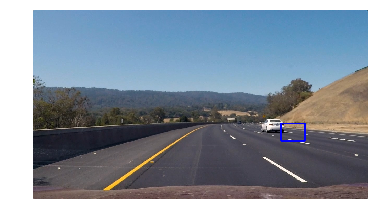

In [68]:
# Search area with normal sized window
window1 = {"y_start":370,"y_stop":570,"x_start":0,"x_stop":1280,"window_size":(135,90),
        "win_per_row":20,"win_per_col":5}
# Search area with small sized windows
window2 = {"y_start":400,"y_stop":500,"x_start":150,"x_stop":1050,"window_size":(90,65),
        "win_per_row":20,"win_per_col":5}
window3 = {"y_start":450,"y_stop":570,"x_start":0,"x_stop":150,"window_size":(150,100),
        "win_per_row":2,"win_per_col":2}
window4 = {"y_start":450,"y_stop":570,"x_start":1050,"x_stop":1280,"window_size":(150,100),
        "win_per_row":2,"win_per_col":2}

window_search_param = [window1,window2, window3, window4]

window_positions = get_window_positions(window_search_param)

print(len(window_positions))

x = 199

plot_and_save_test_imgs(test_imgs[2], y_start, y_stop, rectangle = True, 
                        point_1 = window_positions[x][0], point_2 = window_positions[x][1],
                        img_save = True, save_path = "test2.png")

## 2.2 Get features for windows

In [69]:
def assemble_and_resize_windows(img, window_positions, classifier_shape = classifier_shape):

    window_imgs = []
        
    for position in window_positions:
        tmp_img = img[position[0][1]:position[1][1],position[0][0]:position[1][0],:]
        tmp_img = cv2.resize(tmp_img,dsize=classifier_shape)/255
        window_imgs.append(tmp_img)
        
        
    return np.array(window_imgs)

In [70]:
def make_predictions(imgs,svc, orient, pix_per_cell, cell_per_block, hog_channel, classifier_shape, 
                     features_scaler):
    # Extract features from all input images (windows)
    feature_vector = extract_features(imgs, color_space, orient, pix_per_cell, cell_per_block, hog_channel, 
                                      classifier_shape)
    # Apply the scaler to features
    feature_vector_scaled = features_scaler.transform(feature_vector)
    
    prediction = svc.predict(feature_vector_scaled)
    return prediction

In [71]:
def draw_windows_on_image(img, window_positions, prediction,y_start,y_stop, img_save = False, save_path = None):
    img_plt = np.copy(img)
    for position, pred in zip(window_positions,prediction):
        if pred:
            cv2.rectangle(img_plt, position[0], position[1],(0,0,255),6)
    plt.imshow(img_plt)
    plt.axis("off")
    if img_save:
        plt.imsave(save_path,img_plt)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0. 

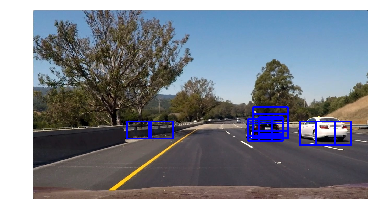

In [72]:
test_imgs_draw = np.copy(test_imgs)

test_imgs_windows = []
test_imgs_predictions = []

for i,img in enumerate(test_imgs_draw):

    window_imgs = assemble_and_resize_windows(img, window_positions=window_positions)

    prediction = make_predictions(window_imgs,svc, orient, pix_per_cell, cell_per_block, hog_channel, 
                                  classifier_shape,features_scaler)
    print(prediction)


    draw_windows_on_image(img, window_positions,prediction, y_start=y_start, y_stop=y_stop, 
                          img_save = True, save_path = "test{}.png".format(str(i)))
    
    test_imgs_windows.append(window_imgs)
    test_imgs_predictions.append(prediction)

## 2.3 Get image heatmap and return window

In [74]:
def get_boxes_for_heatmap(prediction,window_positions):
    """
    Gets boxes for the heatmap and their corresponding weights
    
    Output:
    windows_active: All activated window frames
    weights_windows_active: Weights to be attributed to active window frames
    """
    
    windows_active = []
    weights_windows_active = []
    
    for pre,pos in zip(prediction,window_positions):
        if pre:
            windows_active.append(pos)
            weights_windows_active.append(pre)
        
    windows_active = np.array(windows_active)
    weights_windows_active = np.array(weights_windows_active)
    
    
    return windows_active, weights_windows_active

In [75]:
def add_heat(heatmap, windows_active):
    """
    Add active windows with corresponding weights to heatmap
    
    """
    # Iterate through list of active windows
    for window in windows_active:
        # Add += weight for all pixels inside each bbox
        # Assuming each "window" takes the form ((x1, y1), (x2, y2))
        heatmap[window[0][1]:window[1][1],window[0][0]:window[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [76]:
def apply_threshold(heatmap, threshold):
    """
    Apply threshold to a heatmap
    """
    
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [77]:
#Test
heat = np.zeros((input_image_shape_y,input_image_shape_x))
heat_threshold_single = 1

heatmaps = []
for i in range(len(test_imgs_predictions)):
    windows_active, weights_windows_active = get_boxes_for_heatmap(test_imgs_predictions[i],
                                                                   window_positions)
    heat = np.zeros((input_image_shape_y,input_image_shape_x))
    heatmap = add_heat(heat, windows_active)
    heatmap_thr = apply_threshold(heatmap, heat_threshold_single)
    heatmaps.append(heatmap_thr)
heatmaps = np.array(heatmaps)

In [78]:
print(heatmaps.shape)

(6, 720, 1280)


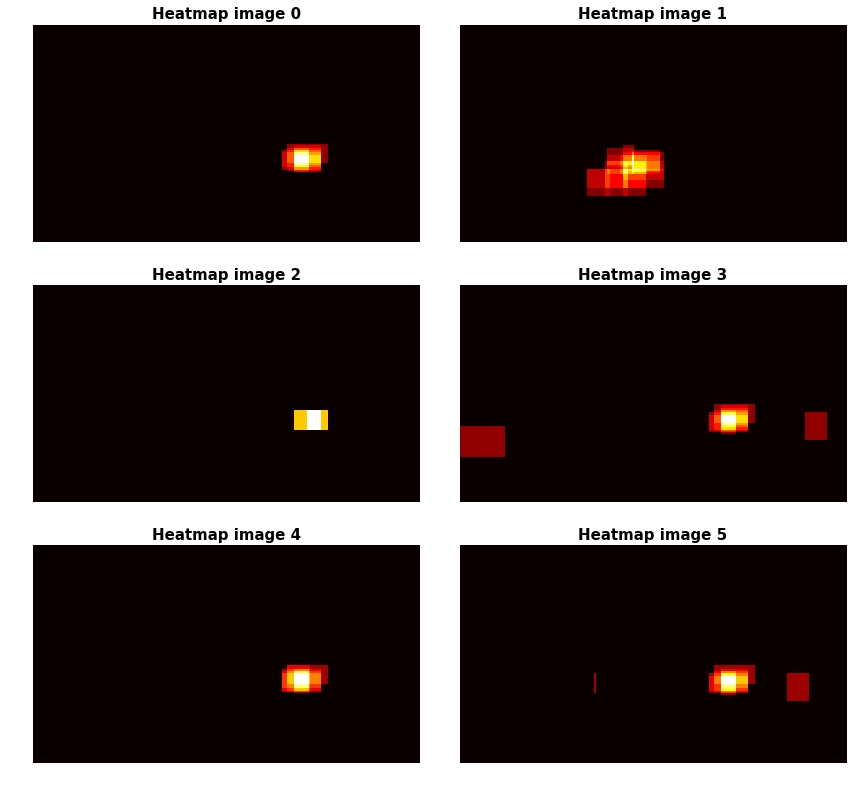

In [79]:
heatmaps_cmaps = ["hot" for i in range(len(heatmaps))]
heatmaps_headings = ["Heatmap image {}".format(str(i)) for i in range(len(heatmaps))]
heatmaps_save_path = "output_images/03_heatmaps.png"

heatmaps_vis = np.array([np.clip(heat, 0, 255) for heat in heatmaps])

plot_and_save_n_images(imgs = heatmaps_vis, cmaps = heatmaps_cmaps, headings = heatmaps_headings,
                       save = True, save_path = heatmaps_save_path,
                       images_per_column = 3, images_per_line = 2, figw = 12, figh = 11)

In [80]:
from scipy.ndimage.measurements import label

labels = []
for heatmap in heatmaps:
    labels.append(label(heatmap))
labels = np.array(labels)

1 cars found


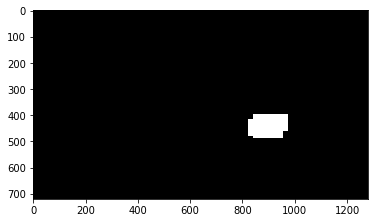

In [81]:
tmp_img_n = 0

print(labels[tmp_img_n][1], 'cars found')
plt.imshow(labels[tmp_img_n][0], cmap='gray')

In [82]:
def split_large_single_detections(labels,heatmap,window_ratio_max):
    """
    Input:
    labels:
    window_ratio_min: Minimum window ratio before window is split (2 cars in 1 detection)
    
    """
    heatmap_tmp = np.copy(heatmap)
    print(labels[1])
    print(range(1,labels[1]+1))
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Determine ratio of window sizes y/x
        y_max = np.max(nonzeroy)
        y_min = np.min(nonzeroy)
        x_max = np.max(nonzerox)
        x_min = np.min(nonzerox)
        bbox_ratio = (y_max-y_min) / (x_max-x_min)
        
        x_middle = x_min + (x_max-x_min)//2
        #print(bbox_ratio)
        if bbox_ratio < window_ratio_max:
            split_size = int((x_max-x_min)*0.1)
            heatmap_tmp[y_min:y_max, (x_middle-split_size):(x_middle+split_size)] = 0
            #print("splitted")
            
    labels_new = label(heatmap_tmp)
    
        
    return labels_new, heatmap_tmp

1
range(1, 2)


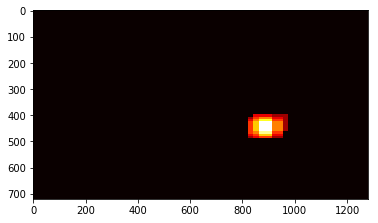

In [83]:
window_ratio_max = 0.5

tmp_img_n = 4

_,example_img = split_large_single_detections(labels[tmp_img_n],heatmaps_vis[tmp_img_n],window_ratio_max)
plt.imshow(example_img,cmap="hot")

In [84]:
def draw_labeled_windows(img, labels):
    # Iterate through all detected cars
    try:
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    except:
        pass
    # Return the image
    return img

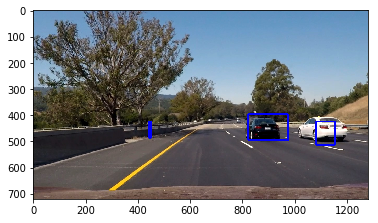

In [85]:
tmp_img_n = 5

example_img = draw_labeled_windows(np.copy(test_imgs[tmp_img_n]),labels[tmp_img_n])
plt.imshow(example_img)

In [86]:
# Not up to date currently

"""# Create overall pipeline


def process_image(img,window_positions,y_start,y_stop, input_image_shape_x, classifier_shape, svc, orient, 
                  pix_per_cell, cell_per_block, hog_channel, features_scaler, prediction_weights,
                  heat_threshold_single, window_ratio_max):
    window_imgs = assemble_and_resize_windows(img,window_positions,y_start,y_stop,classifier_shape)
    prediction = make_predictions(window_imgs,svc, orient, pix_per_cell, cell_per_block, hog_channel, 
                                  classifier_shape,features_scaler)
    windows_active, weights_windows_active = get_boxes_for_heatmap(prediction, window_positions, 
                                                                   prediction_weights)
    heat = np.zeros((y_stop-y_start,input_image_shape_x))
    heatmap = add_heat(heat, windows_active, weights_windows_active)
    heatmap_thr = apply_threshold(heatmap, heat_threshold_single)
    labels = np.array(label(heatmap_thr))
    labels, heatmap_thr = split_large_single_detections(labels,heatmap_thr,window_ratio_max)
    return heatmap_thr, labels"""

'# Create overall pipeline\n\n\ndef process_image(img,window_positions,y_start,y_stop, input_image_shape_x, classifier_shape, svc, orient, \n                  pix_per_cell, cell_per_block, hog_channel, features_scaler, prediction_weights,\n                  heat_threshold_single, window_ratio_max):\n    window_imgs = assemble_and_resize_windows(img,window_positions,y_start,y_stop,classifier_shape)\n    prediction = make_predictions(window_imgs,svc, orient, pix_per_cell, cell_per_block, hog_channel, \n                                  classifier_shape,features_scaler)\n    windows_active, weights_windows_active = get_boxes_for_heatmap(prediction, window_positions, \n                                                                   prediction_weights)\n    heat = np.zeros((y_stop-y_start,input_image_shape_x))\n    heatmap = add_heat(heat, windows_active, weights_windows_active)\n    heatmap_thr = apply_threshold(heatmap, heat_threshold_single)\n    labels = np.array(label(heatmap_thr))\

In [87]:
"""tmp_img_n = 0
heatmap_test, labels_test = process_image(np.copy(test_imgs[tmp_img_n]),window_positions,y_start,y_stop, 
                                          input_image_shape_x, 
                                          classifier_shape, svc, orient, pix_per_cell, cell_per_block, 
                                          hog_channel, features_scaler, prediction_weights,
                                          heat_threshold_single, window_ratio_max)

test_img = draw_labeled_windows(np.copy(test_imgs[tmp_img_n]), labels_test, y_start)
plt.imshow(test_img)
plt.imsave("test.png",test_img)"""

'tmp_img_n = 0\nheatmap_test, labels_test = process_image(np.copy(test_imgs[tmp_img_n]),window_positions,y_start,y_stop, \n                                          input_image_shape_x, \n                                          classifier_shape, svc, orient, pix_per_cell, cell_per_block, \n                                          hog_channel, features_scaler, prediction_weights,\n                                          heat_threshold_single, window_ratio_max)\n\ntest_img = draw_labeled_windows(np.copy(test_imgs[tmp_img_n]), labels_test, y_start)\nplt.imshow(test_img)\nplt.imsave("test.png",test_img)'

# 3 Video Implementation

## 3.1 Define class to store previous image values

In [88]:
class Windows():
    def __init__(self, backlog):
        """
        Input:
        backlog (int): Number of previous images for which data is stored
        """        
        
        # what is the backlog stored in the class
        self.backlog = backlog
        
        # values for previous images
        self.windows = []

    
    
    def update_value_collection(self, update_item, update_value):
        """
        Input:
        update item (list): needs to be a stored list to be updated with a new value
        udate_value: needs to be the value with which the list should be updated
        Output:
        update_item (list): updated list
        """
        udate_item = update_item.append(update_value)
        if len(update_item) > self.backlog:
            update_item = update_item[1:]
        return update_item

    
    def update(self,identified_windows):
        """
        Input:
        identified_windows (list): List of identified windows in the format ((x1,y1),(x2,y2))              
        """
        
        self.windows = self.update_value_collection(self.windows, identified_windows)

## 3.2 Define function to apply processing pipeline on image

In [89]:
def process_video_images(img,window_positions, input_image_shape_x,input_image_shape_y, classifier_shape, 
                         svc, orient, pix_per_cell, cell_per_block, hog_channel, features_scaler, 
                         heat_threshold_multiple, window_ratio_max):
    window_imgs = assemble_and_resize_windows(img,window_positions,classifier_shape)
    prediction = make_predictions(window_imgs,svc, orient, pix_per_cell, cell_per_block, hog_channel, 
                                  classifier_shape,features_scaler)
    if np.sum(prediction) > 0:
        windows_active, weights_windows_active = get_boxes_for_heatmap(prediction, window_positions)
        window_tracker.update(windows_active)
       
    
    heat = np.zeros((input_image_shape_y,input_image_shape_x))    
   
    windows_active_last_imgs = np.concatenate(window_tracker.windows)
    heatmap = add_heat(heat, windows_active_last_imgs)

    heatmap_thr = apply_threshold(heatmap, heat_threshold_multiple)
    labels = np.array(label(heatmap_thr))
    #labels, heatmap_thr = split_large_single_detections(labels,heatmap_thr,window_ratio_max)    
    
    return labels

## 3.3 Process video

In [90]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [91]:
window_tracker = Windows(backlog = 10)
heat_threshold_multiple = 10


# Define a function which only returns the image output of the function "process_image()"
def process_image_video(img):

    labels = process_video_images(img,window_positions, input_image_shape_x,input_image_shape_y, 
                                  classifier_shape, svc, orient, pix_per_cell, cell_per_block, hog_channel, 
                                  features_scaler, heat_threshold_multiple, window_ratio_max)
    result = draw_labeled_windows(np.copy(img), labels)

    return result

In [92]:
# Process the video
video_output = 'test_video_annotated.mp4'
video_input = VideoFileClip("test_video.mp4")
white_clip = video_input.fl_image(process_image_video) #NOTE: this function expects color images!!
%time white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_video_annotated.mp4
[MoviePy] Writing video test_video_annotated.mp4


 97%|█████████▋| 38/39 [00:16<00:00,  2.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_annotated.mp4 

CPU times: user 17.5 s, sys: 9.91 s, total: 27.4 s
Wall time: 18.2 s


In [ ]:
# Ideas for improvements:
#1 Split windows if hight/width not in certain threshold   Done!
# Optimize classifier (wrong window detection on the left) -> Add color component Done!
# Resort images for classifier
# Build class to store values from previous heatmaps and take the average over past 3 heatmaps
# Implement more frames for search in far away images


In [ ]:
x = [1,2,3,4]
y = [11,12,13,14]
z = [21,22,23,24]


for a,b,c in zip(x,y,z):
    print(a+b+c)

In [ ]:
zzz = 31

example = window_imgs[zzz]
print(prediction[zzz])

plt.imshow(example)

In [ ]:
print(window_imgs[zzz].shape)
ggg = make_predictions(window_imgs[zzz:zzz+1],svc, orient, pix_per_cell, cell_per_block, hog_channel, 
                       classifier_shape)

print(ggg)

In [ ]:
print(window_imgs[27])